<a href="https://www.kaggle.com/code/huvinh/svm-kfold-hypertuning?scriptVersionId=204100654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

According to the README.md from https://github.com/zalandoresearch/fashion-mnist, we can use this function from Tensorflow to load the dataset. And it's already split for us.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


It would be more convenient to have the image as a flat vector, i.e. a 784-dimension Numpy array.

In [5]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

Let's have a look at some image.

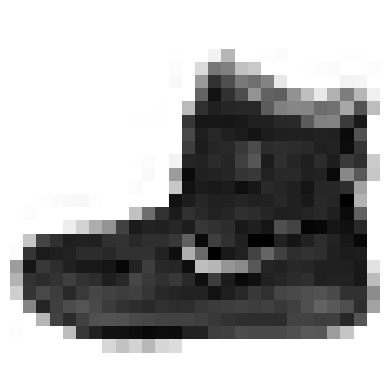

In [6]:
def plot_image(image_data: np.ndarray):
    image_data = image_data.reshape(28, 28)
    plt.imshow(image_data, cmap="binary")
    plt.axis("off")

plot_image(X_train[0])
plt.show()

An image doesn't tell very much though. Let's have a peek at the first 64 images from the train set.

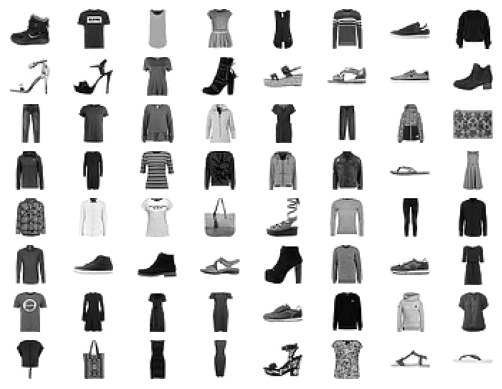

In [7]:
n_rows = 8
n_cols = 8
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index])

From their documentation, the data is already cleaned for us, so no image preprocessing is required (I don't think I'm better than the expert at this).

In [8]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

There are ten classes, with the exact same amount across all of them in both train and test set.
Here are the class names and their corresponding indices:

| Index | Class Name    |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

In [9]:
# Optionally, here are the scaled version of the X sets, though I think you shouldn't use it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# SVM

In [10]:
import cuml
from cuml.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import gc
import torch 

In [9]:
# param_grid = {'C': [0.1, 1, 10, 100]}
# best_score = 0
# best_params = {}

# for C in param_grid['C']:
#     model = LinearSVC(C=C)
#     model.fit(X_train_scaled, y_train)

#     y_pred = model.predict(X_test_scaled)
#     score = accuracy_score(y_test, y_pred)

#     print(f"Accuracy với C={C}: {score}")

#     if score > best_score:
#         best_score = score
#         best_params = {'C': C}

# print("Tham số tốt nhất:", best_params)
# print("Độ chính xác cao nhất:", best_score)

In [10]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

param_grid = {'C': [0.1, 1, 10, 100]}
best_score = 0
best_params = {}

for C in param_grid['C']:
    fold_scores = []
    for train_index, test_index in kf.split(X_train_scaled):
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_fold, y_val = y_train[train_index], y_train[test_index]
        model = LinearSVC(C=C)
        model.fit(X_train, y_train_fold)

        y_pred = model.predict(X_val)
        score = accuracy_score(y_pred, y_val)
        fold_scores.append(score)
        
        del model
        gc.collect()
        torch.cuda.empty_cache()

    avg_score = round(np.mean(fold_scores),6)
    print(f"Độ chính xác trung bình với C={C}: {avg_score}")

    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1: 0.850167
Độ chính xác trung bình với C=1: 0.8491
Độ chính xác trung bình với C=10: 0.8485
Độ chính xác trung bình với C=100: 0.8486
Tham số tốt nhất: {'C': 0.1}
Độ chính xác cao nhất: 0.850167


In [11]:
# param_grid = {
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto','scaled'],
#     'kernel': ['rbf']
# }

# best_score = 0
# best_params = {}

# for C in param_grid['C']:
#     for gamma in param_grid['gamma']:
#         for kernel in param_grid['kernel']:

#             model = SVC(C=C, gamma=gamma, kernel=kernel)
#             model.fit(X_train_scaled, y_train)

#             y_pred = model.predict(X_test_scaled)
#             score = accuracy_score(y_test, y_pred)

#             print(f"Accuracy với C={C}, gamma={gamma}, kernel={kernel}: {score}")

#             if score > best_score:
#                 best_score = score
#                 best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}

#             del model  
#             gc.collect() 
#             torch.cuda.empty_cache() 

# print("Tham số tốt nhất:", best_params)
# print("Độ chính xác cao nhất:", best_score)


In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'auto'],
    'kernel': ['rbf']
}

best_score = 0
best_params = {}

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:

            fold_scores = []

            for train_index, test_index in kf.split(X_train_scaled):
                X_train, X_val = X_train_scaled[train_index], X_train_scaled[test_index]
                y_train_fold, y_val = y_train[train_index], y_train[test_index]

                model = SVC(C=C, gamma=gamma, kernel=kernel)
                model.fit(X_train, y_train_fold)

                y_pred = model.predict(X_val)
                score = accuracy_score(y_val, y_pred)
                fold_scores.append(score)
                
                del model
                gc.collect()
                torch.cuda.empty_cache()

            avg_score = round(np.mean(fold_scores),6)
            print(f"Độ chính xác trung bình với C={C}, gamma={gamma}, kernel={kernel}: {round(avg_score,6)}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}



print("Tham số tốt nhất:", best_params)
print("Độ chính xác cao nhất:", best_score)

Độ chính xác trung bình với C=0.1, gamma=1, kernel=rbf: 0.09755
Độ chính xác trung bình với C=0.1, gamma=0.1, kernel=rbf: 0.09755
Độ chính xác trung bình với C=0.1, gamma=0.01, kernel=rbf: 0.640167
Độ chính xác trung bình với C=0.1, gamma=0.001, kernel=rbf: 0.84755
Độ chính xác trung bình với C=0.1, gamma=0.0001, kernel=rbf: 0.793467
Độ chính xác trung bình với C=0.1, gamma=auto, kernel=rbf: 0.849817
Độ chính xác trung bình với C=1, gamma=1, kernel=rbf: 0.098283
Độ chính xác trung bình với C=1, gamma=0.1, kernel=rbf: 0.178817
Độ chính xác trung bình với C=1, gamma=0.01, kernel=rbf: 0.7991
Độ chính xác trung bình với C=1, gamma=0.001, kernel=rbf: 0.8881
Độ chính xác trung bình với C=1, gamma=0.0001, kernel=rbf: 0.851283
Độ chính xác trung bình với C=1, gamma=auto, kernel=rbf: 0.890633
Độ chính xác trung bình với C=10, gamma=1, kernel=rbf: 0.098333
Độ chính xác trung bình với C=10, gamma=0.1, kernel=rbf: 0.199517
Độ chính xác trung bình với C=10, gamma=0.01, kernel=rbf: 0.810967
Độ chính

In [11]:
class Model:
    def __init__(self, name, model, X_train, y_train, X_test, y_test):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.train_time = None
        self.evaluate_time = None
        self.y_pred = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1_score = None
        self.confusion_matrix = None

    def train(self):
        start_time = time.time()
        self.model.fit(self.X_train, self.y_train)
        self.train_time = time.time() - start_time

    def evaluate(self):
        start_time = time.time()

        self.y_pred = self.model.predict(self.X_test)

        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.precision = precision_score(self.y_test, self.y_pred, average='weighted')
        self.recall = recall_score(self.y_test, self.y_pred, average='weighted')
        self.f1_score = f1_score(self.y_test, self.y_pred, average='weighted')
        self.confusion_matrix = confusion_matrix(self.y_test, self.y_pred)

        self.evaluate_time = time.time() - start_time

    def display_metrics(self):
        print(f"Model Name: {self.name}")
        print(f"Training Time: {self.train_time:.4f} seconds")
        print(f"Evaluation Time: {self.evaluate_time:.4f} seconds")
        print(f"Accuracy: {self.accuracy}")
        print(f"Precision: {self.precision}")
        print(f"Recall: {self.recall}")
        print(f"F1-score: {self.f1_score}")

        plt.figure(figsize=(8, 6))
        sns.heatmap(self.confusion_matrix, cmap="Reds", annot=True, fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

Model Name: Linear Kernel SVC
Training Time: 6.0566 seconds
Evaluation Time: 0.0420 seconds
Accuracy: 0.8406
Precision: 0.8380600697634456
Recall: 0.8406
F1-score: 0.8382018227269551


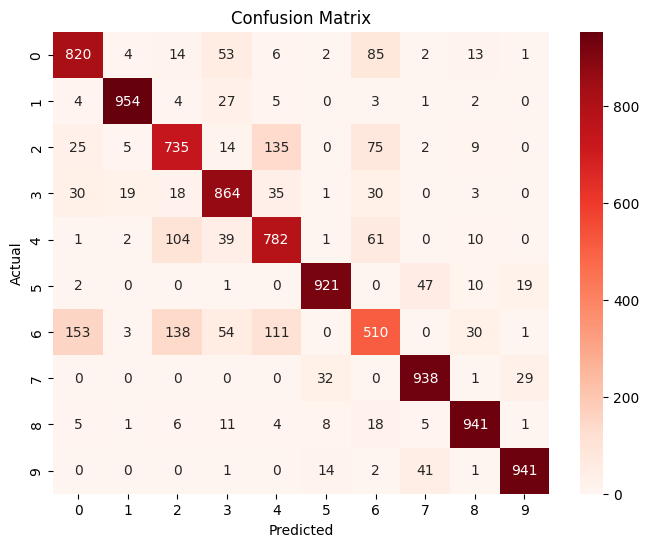

In [13]:
linear = Model(name="Linear Kernel SVC", model=LinearSVC(C=0.1), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
linear.train()
linear.evaluate()
linear.display_metrics()
with open('linear_model.pkl', 'wb') as file:
    pickle.dump(linear.model, file)

Model Name: RBF_SVC
Training Time: 25.3105 seconds
Evaluation Time: 8.3227 seconds
Accuracy: 0.8995
Precision: 0.8992516626922825
Recall: 0.8995
F1-score: 0.8993126761867234


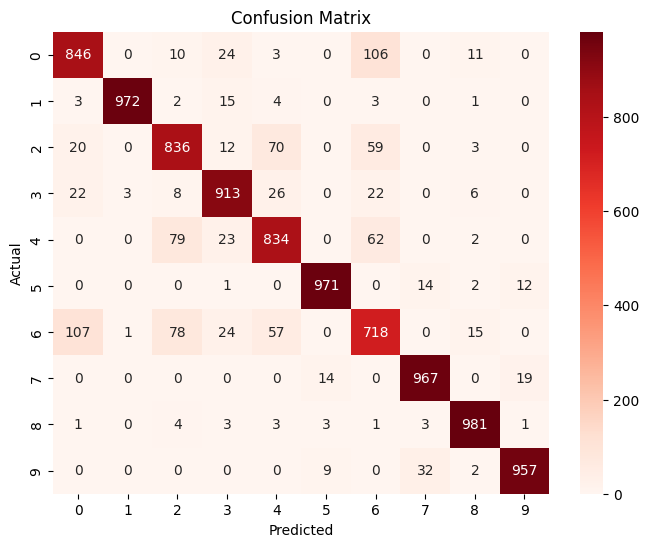

In [15]:
rbf = Model(name="RBF_SVC", model=SVC(C= 10, gamma= 'auto', kernel= 'rbf'), X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)
rbf.train()
rbf.evaluate()
rbf.display_metrics()
with open('rbf_model.pkl', 'wb') as file:
    pickle.dump(rbf.model, file)